In [1]:
%matplotlib inline
import matplotlib 
matplotlib.rc('font', family='arial') 
import matplotlib.pyplot as plt
import numpy as np
import flika as flk
from moviepy.editor import ImageSequenceClip, VideoClip, concatenate_videoclips
from moviepy.video.io.bindings import mplfig_to_npimage
from fish.image.zds import ZDS
from matplotlib.cm import gray, inferno

from dask.distributed import Client
from fish.util.distributed import get_cluster
from dask.array import coarsen
import dask.array as da
from skimage.io import imread
from scipy.ndimage.filters import median_filter
from functools import partial
from glob import glob
from skimage.exposure import rescale_intensity as rescale
flk.start_flika()

Starting flika


Starting flika inside IPython


In [2]:
def mydff(v):
    from fish.image.vol import dff
    camera_offset = 80
    window = 400
    percentile = 20
    offset = 10    
    downsample = 10;
    return dff((v - camera_offset).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')

def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0]    
    return shift(im.astype('float32'), (0,0, *shifts[t]), order=1, cval=100)

def reg(fixed, moving):
    from fish.image.alignment import estimate_translation    
    from numpy import expand_dims
    affs =  estimate_translation(fixed.squeeze(), moving.squeeze()).affine
    return expand_dims(affs, 0)

In [3]:
base_dirs = ('/nrs/ahrens/Yu/SPIM/active_dataset/20170131/fish5/20170131_5_1_GFAPRGECO_DBHGC5slow_5dpf_waist_CLPause_0GAIN_GAINMODULATION_20170131_220542/',)

In [4]:
base_dir = base_dirs[0] 
dset = ZDS(base_dir + 'raw/')
data = dset.data
exp_name = dset.metadata['data_header']
reg_path = base_dir + 'regparams_affine.npy'
medfilt = partial(median_filter, size=(1,1,5,5))
data_filt = data.map_blocks(medfilt)    
print('calculating reference image')
anat_ref = data_filt[data_filt.shape[0]//2 + np.arange(-5,5)].mean(0).compute(scheduler='threads')

try: 
    shifts = -np.load(reg_path)[:,:-1,-1]
except FileNotFoundError:
    shifts = None    
    print('No valid regparams found. They will be estimated')
data.shape

calculating reference image


(8500, 28, 1980, 1056)

In [5]:
cluster = get_cluster()
client = Client(cluster)
client

Client Scheduler: tcp://10.36.110.35:39428 Dashboard: http://10.36.110.35:35940/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
if shifts is None:
    import time
    cluster.start_workers(320)
    time.sleep(10)
    ref_mx_bc = client.scatter(anat_ref.max(0), broadcast=True)
    affines = data_filt.max(1).map_blocks(lambda a,b: reg(b, a), ref_mx_bc, dtype='float32', chunks=(1,2,2)).compute()
    cluster.stop_workers(cluster.workers)
    np.save(reg_path, affines)
    shifts = -affines[:,:-1,-1]    

In [7]:
roi = (slice(None), slice(0,None), slice(None), slice(None))
out_path = f'/nrs/ahrens/davis/ngm/{exp_name}_mx_t{roi[0].start}t{roi[0].stop}.tif'
data_tx = data[roi].map_blocks(shift_yx, shifts[roi[0]], dtype='float32')
data_filt = data_tx.map_blocks(lambda v: median_filter(v, size=(1,1,3,3)))
ds_xy = 4
data_ds = coarsen(np.mean, data_filt, {2: ds_xy, 3: ds_xy})
rechunked = data_ds.rechunk(chunks=(data_ds.shape[0], 1, 32,32))
data_dff = rechunked.map_blocks(mydff, dtype='float32').max(1)

In [ ]:
import time
cluster.start_workers(400)
time.sleep(10)
result = data_filt.max(1).compute()
cluster.stop_workers(cluster.workers)

In [ ]:
from skimage.io import imsave, imread
imsave(out_path, result)

In [8]:
result = imread(out_path)

In [9]:
result.shape

(8500, 495, 264)

In [10]:
# get some behavior
from fish.ephys.ephys import load, estimate_onset
from h5py import File
epd = File(base_dir + 'ephys/data.mat','r')['data']
ep_raw = load(glob(base_dir +'ephys/*.10chFlt')[0])

swim = epd['fltCh2'][:].squeeze() + epd['fltCh1'][:].squeeze()
frame = estimate_onset(ep_raw[2], threshold=3.6, duration=100)[:result.shape[0]]
gain_signal = ep_raw[-1]

In [11]:
result = result[:,::-1,]
crop = (slice(0, None), slice(10, -10))

In [12]:
anat = gray(rescale(result.max(0)[crop], in_range=(0,4), out_range=(0,1))) * np.array([.5,.5,.5,1])

Text(0,0.5,'Fictive behavior')

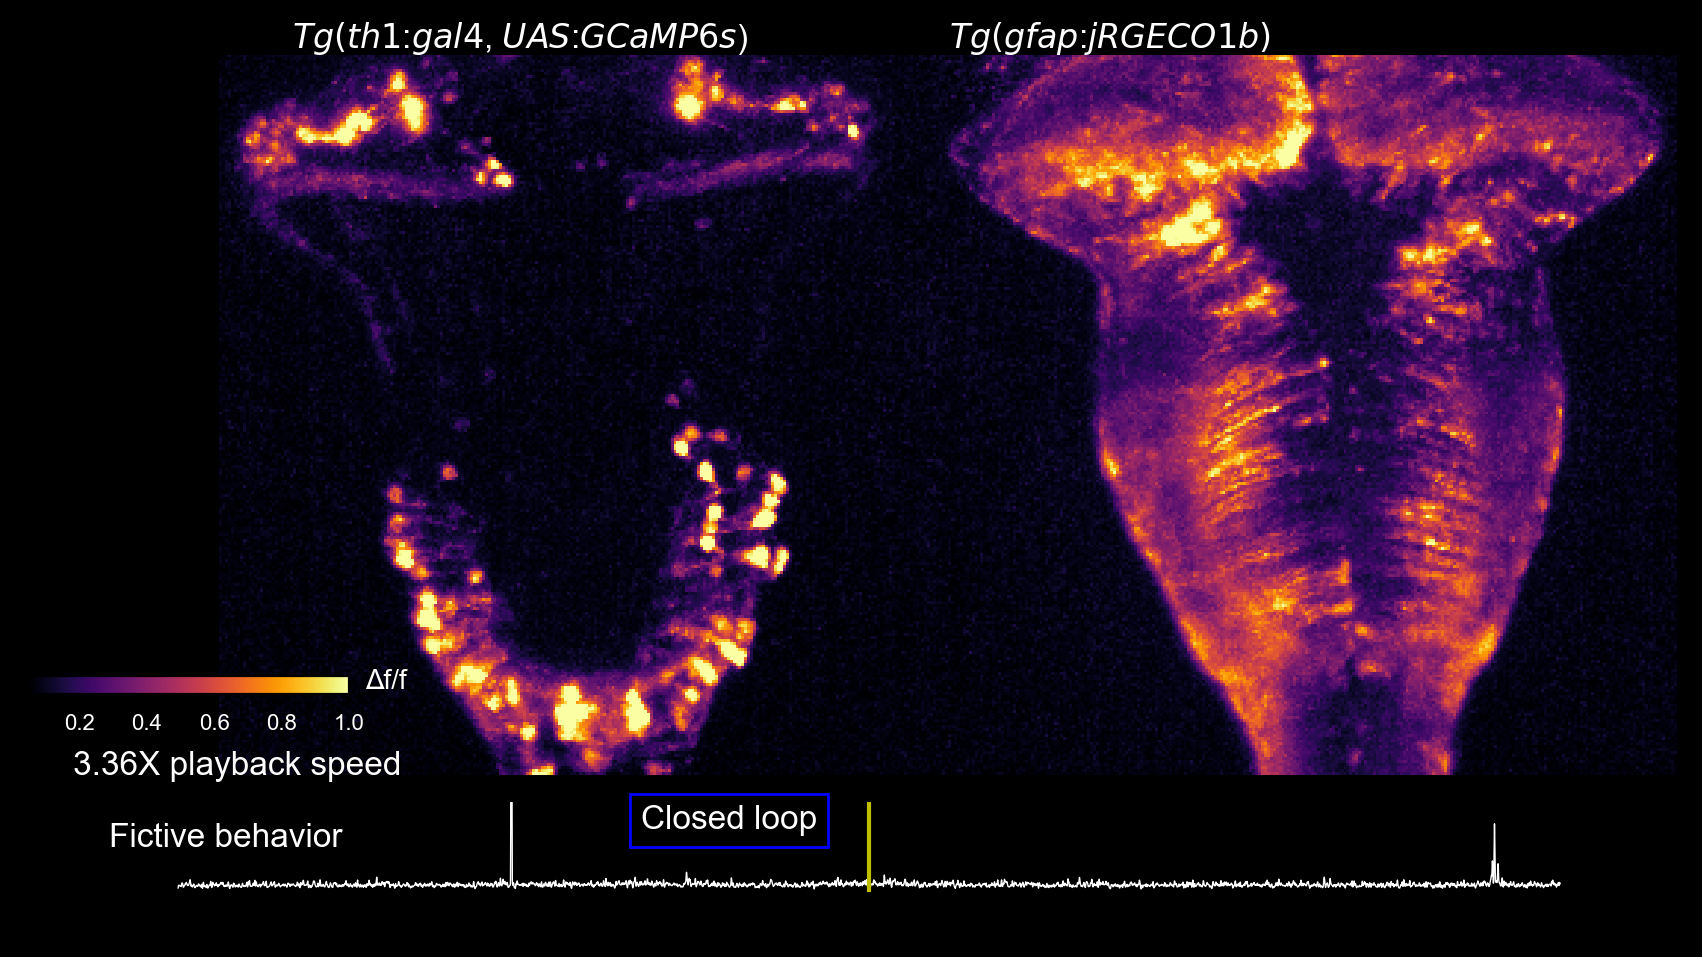

In [49]:
fps = 8
flash_dur = 3
plr = np.arange(1600,1800)
fs_ep = 6000
window_ep = np.arange(-8 * fs_ep, 8 * fs_ep)
in_range_dff = (.05,1)
figsize = (16/2, 9/2)
fig_dff, axs_dff = plt.subplots(dpi=200, figsize=figsize)
axs_dff.set_position([.1,.15,.95,.8])

t_ep = frame[plr[0]]
axs_ep = fig_dff.add_axes([.05,.02,.95,.1])
axs_ep.plot(window_ep, swim[range(len(window_ep))], color='w', linewidth=.5)
axs_ep.axvline(0, color='y')

#axs_ep.set_xlim(ep_plr[0], ep_plr[-1])
axs_ep.set_ylim(0, .002)

axs_cbar = fig_dff.add_axes([0, .24, .2, .02])

[x.axis('off') for x in (axs_dff, axs_ep)]
[x.set_facecolor('k') for x in (axs_dff, axs_ep, fig_dff)]
axs_dff.axis('off')

im_dff = axs_dff.imshow(result[0][crop].transpose(1,0), cmap='inferno', clim = in_range_dff)
cbar = plt.colorbar(axs_dff.images[0], cax=axs_cbar, orientation='horizontal')
axs_cbar.text(1.05, .3, '\u0394f/f', transform=axs_cbar.transAxes, fontdict={'fontsize' : 10, 'color' : 'w'})
axs_cbar.tick_params(labelcolor='w', labelsize=8)

label_font = dict(color='w', size=12)
th1_label = dict(x = .05, y=1.01, s='$\it{Tg(th1}$:$\it{gal4}$, $\it{UAS}$:$\it{GCaMP6s}$)', transform=axs_dff.transAxes, fontdict=label_font)
rgeco_label = dict(x = .5, y=1.01, s='$\it{Tg(gfap}$:$\it{jRGECO1b)}$', transform=axs_dff.transAxes, fontdict=label_font)
beh_label = dict(x = 0, y=.5, s='Fictive behavior', transform=axs_ep.transAxes, fontdict=label_font)
timing_label = dict(x = -.1, y = 0, s=f'{fps/dset.metadata["volume_rate"]:.2f}X playback speed',transform=axs_dff.transAxes, fontdict=label_font)

gain_conds = ('Closed loop', 'Open loop')
gain_colors = ('b','y')

cond_label = axs_ep.text(.35, 
                        .7, 
                        gain_conds[(gain_signal[t_ep] == 0.0).astype('int')], 
                        transform=axs_ep.transAxes, 
                        fontdict={'fontsize' : 12, 'color' : 'w'}, 
                        bbox=dict(edgecolor=gain_colors[(gain_signal[t_ep] == 0.0).astype('int')], facecolor='k'))
                    
                    
axs_dff.text(**th1_label)
axs_dff.text(**rgeco_label)
axs_dff.text(**timing_label)
axs_ep.text(**beh_label)

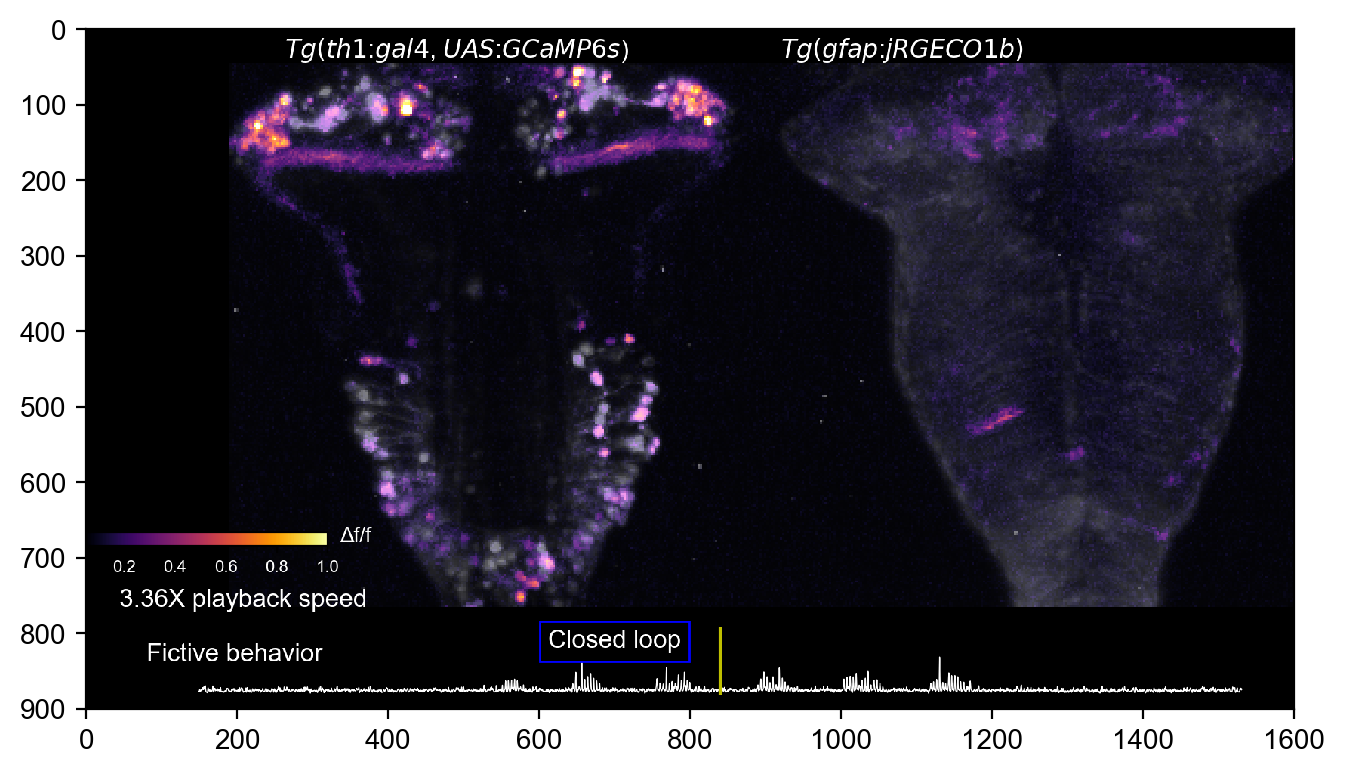

In [57]:
def draw_frame(t_):
    global ind
    if t_ == 0.0:
        ind = plr[0]
        
    ep_plr = window_ep + frame[ind]
    axs_ep.lines[0].set_data(window_ep, swim[ep_plr])
    
    composite = anat + inferno(rescale(result[ind][crop], in_range=in_range_dff, out_range=(0,1)))
    im_dff.set_data(composite.transpose(1,0,2))
    
    t_ep = frame[ind]       
    gain_switched = (gain_signal[t_ep] == 0.0) and (gain_signal[t_ep - flash_dur * fs_ep] > 0.0)    
    g_ind = (gain_signal[t_ep] == 0.0).astype('int')
    
    cond_box_label_color = gain_colors[g_ind]
    if gain_switched:
        cond_box_label_color=gain_colors[ind % 2]    
    cond_label.set_text(gain_conds[g_ind])
    cond_label.set_bbox(dict(edgecolor=cond_box_label_color, facecolor='k'))
    
    ind += 1
    return mplfig_to_npimage(fig_dff)

a,b = plt.subplots(figsize=figsize, dpi=200)
b.imshow(draw_frame(0))

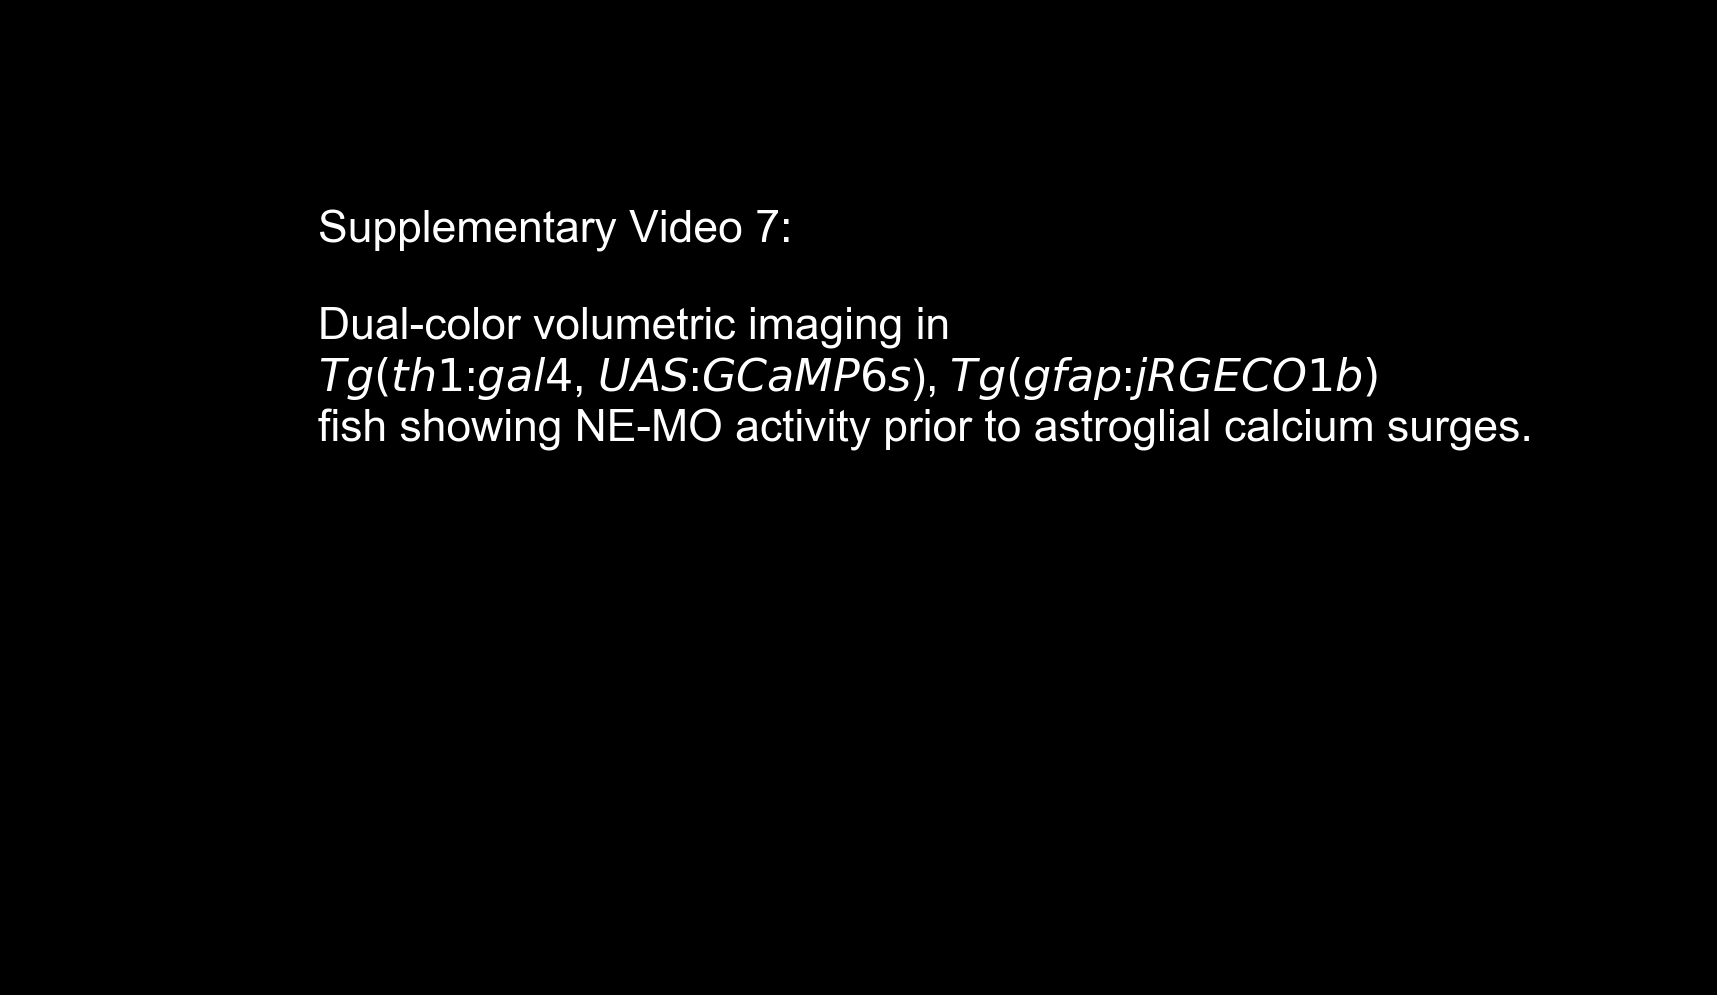

In [68]:
## make the title card 
title_dur = 4
fig_intro = plt.figure(dpi=200, figsize=np.array(figsize), facecolor='k')
ax_intro = fig_intro.add_axes((0,0,1,1))
ax_intro.set_facecolor('k')
intro_text =r'''Supplementary Video 7:

Dual-color volumetric imaging in 
$\it{Tg(th1}$:$\it{gal4}$, $\it{UAS}$:$\it{GCaMP6s}$), $\it{Tg(gfap}$:$\it{jRGECO1b)}$
fish showing NE-MO activity prior to astroglial calcium surges.             
'''
            
ax_intro.text(.15,
              .8,
              intro_text, 
              fontdict=dict(color='w', size=16), 
              transform=ax_intro.transAxes, 
              ha = 'left',
              va='top',
              multialignment='left')

def drawf_intro(t_):
    return mplfig_to_npimage(fig_intro)

title_clip = VideoClip(drawf_intro, duration=title_dur)

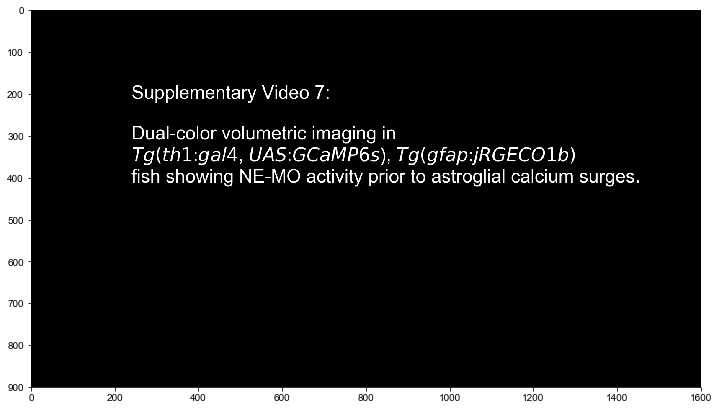

In [69]:
_,_  = plt.subplots(figsize=(12,12))
plt.imshow(drawf_intro(0))

In [70]:
import shutil
data_dur = len(plr) / fps
data_clip = VideoClip(draw_frame, duration=data_dur)

codec = 'h264'
vid_fname = f'/groups/ahrens/ahrenslab/davis/tmp/{exp_name}_t{roi[0].start}t{roi[0].stop}.mp4'
ind = plr[0]

composite_clip = concatenate_videoclips([title_clip, data_clip])
composite_clip.write_videofile(vid_fname, audio=False, codec=codec, fps=fps, ffmpeg_params=['-pix_fmt', 'yuv420p'])
shutil.copyfile(vid_fname, '/groups/ahrens/ahrenslab/davis/tmp/Supplementary_Video_7.mp4')

[MoviePy] >>>> Building video /groups/ahrens/ahrenslab/davis/tmp/20170131_5_1_GFAPRGECO_DBHGC5slow_5dpf_waist_CLPause_0GAIN_GAINMODULATION_tNonetNone.mp4
[MoviePy] Writing video /groups/ahrens/ahrenslab/davis/tmp/20170131_5_1_GFAPRGECO_DBHGC5slow_5dpf_waist_CLPause_0GAIN_GAINMODULATION_tNonetNone.mp4


100%|█████████▉| 232/233 [01:00<00:00,  3.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /groups/ahrens/ahrenslab/davis/tmp/20170131_5_1_GFAPRGECO_DBHGC5slow_5dpf_waist_CLPause_0GAIN_GAINMODULATION_tNonetNone.mp4 



'/groups/ahrens/ahrenslab/davis/tmp/Supplementary_Video_7.mp4'